In [28]:
import pandas as pd 
import numpy as np
import os
import torch
from f1tenth_benchmarks.run_scripts.run_functions import *
from matplotlib.collections import LineCollection
from f1tenth_benchmarks.utils.MapData import MapData
from f1tenth_benchmarks.data_tools.plotting_utils import *
from f1tenth_benchmarks.utils.track_utils import CentreLine
from f1tenth_benchmarks.localmap_racing.LocalMap import LocalMap
from scipy import interpolate
from trajectory_planning_helpers.calc_head_curv_num import calc_head_curv_num
%matplotlib inline
import mpld3
mpld3.enable_notebook()

if os.getcwd().split('/')[-1] == 'Notebooks':
    os.chdir('..')
    print(f'Changed directory to root of repo: {os.getcwd()}')


def ensure_path_exists(path):
    if not os.path.exists(path): 
        os.mkdir(path)

save_path = 'Data/LocalMapRacing/'
ensure_path_exists(save_path)

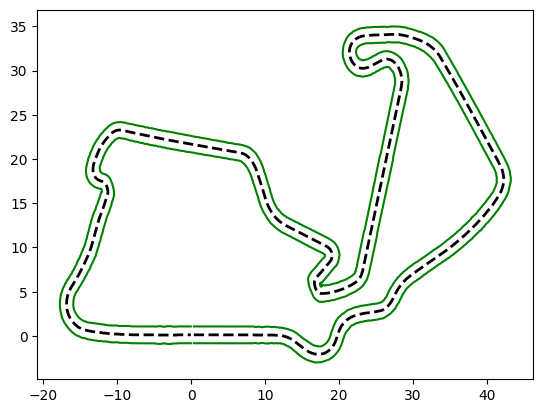

In [29]:
map_name = "gbr"
track = CentreLine(map_name)

# Create a figure without specifying the figsize to allow the plot to scale
plt.figure()

# Plotting the track centerline
plt.plot(track.path[:, 0], track.path[:, 1], '--', linewidth=2, color='black')

# Plotting the inner and outer boundaries of the track
l1 = track.path[:, :2] + track.nvecs * track.widths[:, 0][:, None]
l2 = track.path[:, :2] - track.nvecs * track.widths[:, 1][:, None]
plt.plot(l1[:, 0], l1[:, 1], color='green')
plt.plot(l2[:, 0], l2[:, 1], color='green')

# Display the plot
plt.show()


Original Points: 1182
Smothed Points: 1182
Resampled Points: 1184


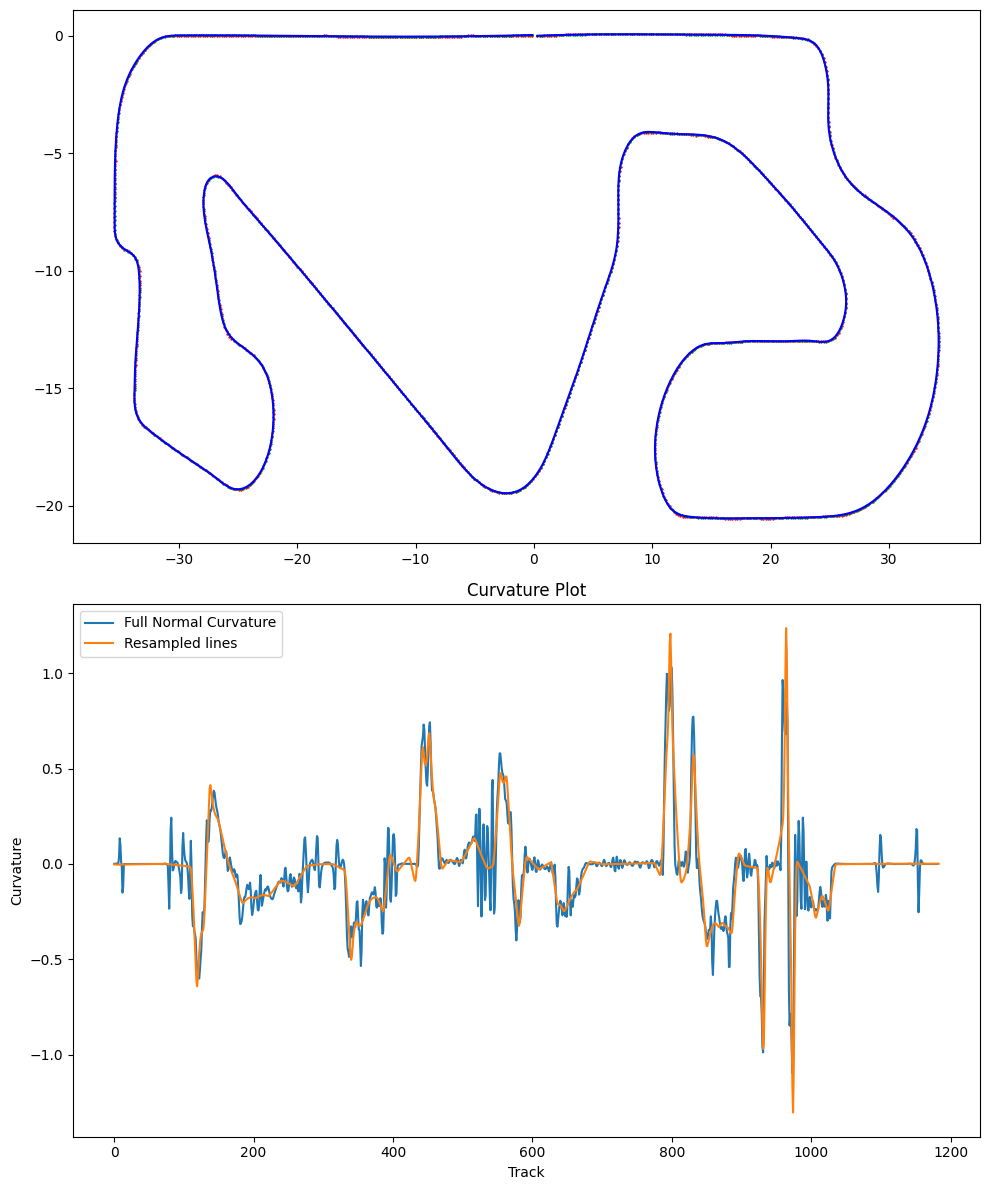

In [53]:
def interpolate_track_new(points, n_points=None, s=0):
    if len(points) <= 1:
        return points
    order_k = min(3, len(points) - 1)
    tck = interpolate.splprep([points[:, 0], points[:, 1]], k=order_k, s=s)[0]
    if n_points is None: n_points = len(points)
    track = np.array(interpolate.splev(np.linspace(0, 1, n_points), tck)).T
    return track

def resample_track_points(points, seperation_distance=0.2, smoothing=0.2):
    if points[0, 0] > points[-1, 0]:
        points = np.flip(points, axis=0)

    line_length = np.sum(np.linalg.norm(np.diff(points, axis=0), axis=1))
    n_pts = max(int(line_length / seperation_distance), 2)
    smooth_line = interpolate_track_new(points, None, smoothing)
    resampled_points = interpolate_track_new(smooth_line, n_pts, 0)

    return resampled_points, smooth_line


map_name = "esp"
track = CentreLine(map_name)
kappa = track.kappa
path = track.path




# Create a figure without specifying the figsize to allow the plot to scale
# plt.figure()

# Plotting the track centerline
# plt.plot(track.path[:, 0], track.path[:, 1], '.', linewidth=2, color='black')
points = track.path

# Resample the points using the function
resampled_points, smooth_line = resample_track_points(points, seperation_distance=0.2, smoothing=0.5)
print(f'Original Points: {len(points)}')
print(f'Smothed Points: {len(smooth_line)}')
print(f'Resampled Points: {len(resampled_points)}')

fig, axs = plt.subplots(2, 1, figsize=(10, 12)) 

# Plot the original points
axs[0].scatter(points[:, 0], points[:, 1], color='red', label='Original Points', s =0.5)

# Plot the smoothed line
axs[0].plot(smooth_line[:, 0], smooth_line[:, 1], color='blue', label='Smoothed Line')

# Plot the resampled points
axs[0].scatter(resampled_points[:, 0], resampled_points[:, 1], color='green', label='Resampled Points', s =0.5)


el_lengthsSmooth = np.sqrt(np.sum(np.diff(smooth_line, axis=0)**2, axis=1))
psiSmooth, kappaSmooth = calc_head_curv_num(
        path=smooth_line,
        el_lengths=el_lengthsSmooth,
        is_closed=False,
        stepsize_psi_preview=0.1,
        stepsize_psi_review=0.1,
        stepsize_curv_preview=0.2,
        stepsize_curv_review=0.2,
        calc_curv=True
    )

el_lengthsSmooth2 = np.sqrt(np.sum(np.diff(resampled_points, axis=0)**2, axis=1))
psiSmooth2, kappaSmooth2 = calc_head_curv_num(
        path=resampled_points,
        el_lengths=el_lengthsSmooth2,
        is_closed=False,
        stepsize_psi_preview=0.1,
        stepsize_psi_review=0.1,
        stepsize_curv_preview=0.2,
        stepsize_curv_review=0.2,
        calc_curv=True
    )

axs[1].plot(kappa, label='Full Normal Curvature')
# axs[1].plot(np.flip(-kappaSmooth), label='Smoothed lines')
axs[1].plot(np.flip(-kappaSmooth2), label='Resampled points')

axs[1].set_title("Curvature Plot")
axs[1].legend()
axs[1].set_xlabel("Track")
axs[1].set_ylabel("Curvature")
# axs[1].plot(kappaSmooth2, label='Resampled points')

# # Plotting the inner and outer boundaries of the track
# l1 = track.path[:, :2] + track.nvecs * track.widths[:, 0][:, None]
# l2 = track.path[:, :2] - track.nvecs * track.widths[:, 1][:, None]
# plt.plot(l1[:, 0], l1[:, 1], color='green')
# plt.plot(l2[:, 0], l2[:, 1], color='green')

# Display the plot
plt.tight_layout()
plt.show()



